In [1]:
!pip install torchsummary
import os
import sys
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision import models
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from torchsummary import summary
import json

In [2]:
def create_image_dataframe(folder_path):
    data = []

    # Iterate through each subfolder in the main folder
    for subfolder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder_name)
        
        # Ensure it's a directory
        if os.path.isdir(subfolder_path):
            # Iterate through each image file in the subfolder
            for image_name in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_name)
                
                try:
                    # Open the image file
                    image = Image.open(image_path)
                    # Resize image to 256x256
                    image = image.resize((256, 256))
                    # Convert image to greyscale
                    image = image.convert('L')
                    
                    # Append the processed image and its label to the data list
                    data.append((image, subfolder_name))
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")

    # Create a DataFrame with columns 'image' and 'label'
    df = pd.DataFrame(data, columns=['image', 'label'])

    return df

In [3]:
def summarize_dataframe(df):
    # Convert PIL images to a format that can be used in DataFrame operations
    df['image'] = df['image'].apply(lambda img: img.tobytes())

    # Number of rows in the DataFrame
    num_rows = len(df)
    
    # Unique values for each column
    unique_values = df.nunique()
    
    # Count of instances for each unique value in the 'label' column
    value_counts = df['label'].value_counts()
    
    # Summary of the DataFrame
    summary = df.describe(include='all')
    
    # Display the information
    print("Number of rows:", num_rows)
    print("\nUnique values for each column:")
    print(unique_values)
    print("\nCount of instances for each unique value in the 'label' column:")
    print(value_counts)
    print("\nSummary of the DataFrame:")
    print(summary)

    # Convert the 'image' column back to PIL images
    df['image'] = df['image'].apply(lambda img_bytes: Image.frombytes('L', (256, 256), img_bytes))

    return df

In [4]:
folder_path = '/kaggle/input/lung-x-ray-image-clinical-text-dataset/Merged Data (image+text)'
df = create_image_dataframe(folder_path)
df.head()

,image,label
0,<PIL.Image.Image image mode=L size=256x256 at ...,Encapsulated Lesions
1,<PIL.Image.Image image mode=L size=256x256 at ...,Encapsulated Lesions
2,<PIL.Image.Image image mode=L size=256x256 at ...,Encapsulated Lesions
3,<PIL.Image.Image image mode=L size=256x256 at ...,Encapsulated Lesions
4,<PIL.Image.Image image mode=L size=256x256 at ...,Encapsulated Lesions


In [5]:
df = summarize_dataframe(df)

Number of rows: 80000

Unique values for each column:
image    80000
label        8
dtype: int64

Count of instances for each unique value in the 'label' column:
label
Encapsulated Lesions                10000
Lower Density                       10000
Degenerative Infectious Diseases    10000
Normal                              10000
Higher Density                      10000
Obstructive Pulmonary Diseases      10000
Mediastinal Changes                 10000
Chest Changes                       10000
Name: count, dtype: int64

Summary of the DataFrame:
                                                    image  \
count                                               80000   
unique                                              80000   
top     b'\x06\x06\x06\x06\x06\x06\x06\x06\x00\x00\x00...   
freq                                                    1   

                       label  
count                  80000  
unique                     8  
top     Encapsulated Lesions  
freq         

In [6]:
df

,image,label
0,<PIL.Image.Image image mode=L size=256x256 at ...,Encapsulated Lesions
1,<PIL.Image.Image image mode=L size=256x256 at ...,Encapsulated Lesions
2,<PIL.Image.Image image mode=L size=256x256 at ...,Encapsulated Lesions
3,<PIL.Image.Image image mode=L size=256x256 at ...,Encapsulated Lesions
4,<PIL.Image.Image image mode=L size=256x256 at ...,Encapsulated Lesions
...,...,...
79995,<PIL.Image.Image image mode=L size=256x256 at ...,Chest Changes
79996,<PIL.Image.Image image mode=L size=256x256 at ...,Chest Changes
79997,<PIL.Image.Image image mode=L size=256x256 at ...,Chest Changes
79998,<PIL.Image.Image image mode=L size=256x256 at ...,Chest Changes


In [7]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.dataframe['label'] = self.label_encoder.fit_transform(self.dataframe['label'])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        
        return image, label

    def get_labels(self):
        return self.label_encoder.classes_

    def inverse_transform_labels(self, labels):
        return self.label_encoder.inverse_transform(labels)

    def decode_label(self, label):
        return self.label_encoder.inverse_transform([label])[0]

class LossAccuracyPlottingCallback:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.train_losses_steps = []
        self.val_losses_steps = []
        self.train_accuracies_steps = []
        self.val_accuracies_steps = []

    def on_epoch_end(self, train_loss, val_loss, train_accuracy, val_accuracy):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_accuracies.append(train_accuracy)
        self.val_accuracies.append(val_accuracy)

    def on_step_end(self, train_loss, val_loss, train_accuracy, val_accuracy):
        self.train_losses_steps.append(train_loss)
        self.val_losses_steps.append(val_loss)
        self.train_accuracies_steps.append(train_accuracy)
        self.val_accuracies_steps.append(val_accuracy)

    def plot_and_save(self):
        # Plot and save epoch-wise loss graph
        plt.figure()
        plt.plot(self.train_losses, label="Training Loss (Epochs)")
        plt.plot(self.val_losses, label="Validation Loss (Epochs)")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training and Validation Loss (Epochs)")
        plt.savefig("loss_plot_epochs.png")
        plt.close()

        # Plot and save epoch-wise accuracy graph
        plt.figure()
        plt.plot(self.train_accuracies, label="Training Accuracy (Epochs)")
        plt.plot(self.val_accuracies, label="Validation Accuracy (Epochs)")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Training and Validation Accuracy (Epochs)")
        plt.savefig("accuracy_plot_epochs.png")
        plt.close()

        # Plot and save step-wise loss graph
        plt.figure()
        plt.plot(self.val_losses_steps, label="Validation Loss (Steps)")
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training and Validation Loss (Steps)")
        plt.savefig("loss_plot_steps.png")
        plt.close()

        # Plot and save step-wise accuracy graph
        plt.figure()
        plt.plot(self.val_accuracies_steps, label="Validation Accuracy (Steps)")
        plt.xlabel("Steps")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Training and Validation Accuracy (Steps)")
        plt.savefig("accuracy_plot_steps.png")
        plt.close()

In [8]:
def split_dataset(df, test_size=0.2, val_size=0.3):
    train_val_df, test_df = train_test_split(df, test_size=test_size, stratify=df['label'])
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, stratify=train_val_df['label'])
    
    return train_df, val_df, test_df

In [9]:
def train_model(train_df, val_df, test_df, num_epochs=10, batch_size=32, learning_rate=0.001):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale images to 3 channels
        transforms.ToTensor()
    ])

    train_dataset = ImageDataset(train_df, transform=transform)
    val_dataset = ImageDataset(val_df, transform=transform)
    test_dataset = ImageDataset(test_df, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_dataset.get_labels()))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    callback = LossAccuracyPlottingCallback()

    best_val_loss = float('inf')
    step = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

            # Record step-wise metrics
            step_loss = loss.item()
            step_accuracy = (predicted == labels).float().mean().item()
            callback.on_step_end(step_loss, step_loss, step_accuracy, step_accuracy)
            step += 1

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)
        
        callback.on_epoch_end(train_loss, val_loss, train_accuracy, val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    callback.plot_and_save()

    # Save training history
    history = {
        'train_losses': callback.train_losses,
        'val_losses': callback.val_losses,
        'train_accuracies': callback.train_accuracies,
        'val_accuracies': callback.val_accuracies,
        'train_losses_steps': callback.train_losses_steps,
        'val_losses_steps': callback.val_losses_steps,
        'train_accuracies_steps': callback.train_accuracies_steps,
        'val_accuracies_steps': callback.val_accuracies_steps
    }

    with open('training_history.txt', 'w') as f:
        json.dump(history, f)

    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test F1 Score: {f1:.4f}')

    # Convert numerical labels back to original labels
    original_labels = train_dataset.inverse_transform_labels(all_labels)
    original_preds = train_dataset.inverse_transform_labels(all_preds)

    # Assuming original_labels and original_preds are already defined
    cm = confusion_matrix(original_labels, original_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.get_labels())

    # Adjust the plot size and plot the confusion matrix
    plt.figure(figsize=(10, 10))  # Increase figure size if needed
    disp.plot(cmap='Blues')

    # Rotate the x-axis labels to be vertical
    plt.xticks(rotation=90)

    # Save the confusion matrix plot with tight layout and high DPI
    plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
    plt.show()

    return model

In [10]:
num_epochs=10
batch_size=124
learning_rate=0.00001

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 111MB/s] 


Epoch 1/10, Train Loss: 1.7564, Train Accuracy: 0.4081, Validation Loss: 1.3058, Validation Accuracy: 0.6189
Epoch 2/10, Train Loss: 1.0845, Train Accuracy: 0.6740, Validation Loss: 0.7373, Validation Accuracy: 0.7785
Epoch 3/10, Train Loss: 0.6316, Train Accuracy: 0.8210, Validation Loss: 0.3776, Validation Accuracy: 0.8978
Epoch 4/10, Train Loss: 0.3582, Train Accuracy: 0.9042, Validation Loss: 0.1985, Validation Accuracy: 0.9463
Epoch 5/10, Train Loss: 0.2160, Train Accuracy: 0.9439, Validation Loss: 0.1136, Validation Accuracy: 0.9704
Epoch 6/10, Train Loss: 0.1417, Train Accuracy: 0.9625, Validation Loss: 0.0675, Validation Accuracy: 0.9829
Epoch 7/10, Train Loss: 0.0962, Train Accuracy: 0.9754, Validation Loss: 0.0423, Validation Accuracy: 0.9894
Epoch 8/10, Train Loss: 0.0698, Train Accuracy: 0.9828, Validation Loss: 0.0284, Validation Accuracy: 0.9931
Epoch 9/10, Train Loss: 0.0543, Train Accuracy: 0.9863, Validation Loss: 0.0201, Validation Accuracy: 0.9948
Epoch 10/10, Train 

<Figure size 1000x1000 with 0 Axes>

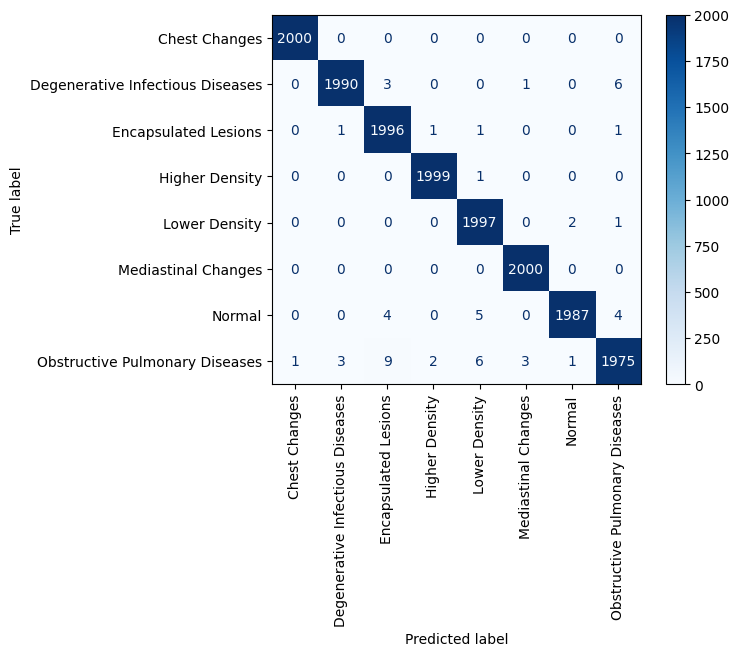

In [11]:
train_df, val_df, test_df = split_dataset(df)
model = train_model(train_df, val_df, test_df, num_epochs, batch_size, learning_rate)
torch.save(model.state_dict(), 'model.pth')

In [12]:
model.load_state_dict(torch.load('model.pth'))
model_eval = model.eval()
with open('model_eval.txt', 'w') as f:
    # Capture the summary output
    old_stdout = sys.stdout
    sys.stdout = f
    model_eval
    # Reset stdout
    sys.stdout = old_stdout

In [13]:
from torchsummary import summary

with open('model_summary.txt', 'w') as f:
    # Capture the summary output
    old_stdout = sys.stdout
    sys.stdout = f
    summary(model, input_size=(3, 256, 256))
    # Reset stdout
    sys.stdout = old_stdout

print("Model summary saved to model_summary.txt")

Model summary saved to model_summary.txt


In [14]:
def plot_weights_distribution(model, filename='weights_distribution.png'):
    plt.figure(figsize=(10, 5))
    for name, param in model.named_parameters():
        if 'weight' in name:
            plt.hist(param.cpu().detach().numpy().flatten(), bins=50, alpha=0.5)
    plt.xlim(-2, 2)
    plt.title('Weights Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.savefig(filename, bbox_inches='tight')  # Save the plot in PNG format
    plt.close()  # Close the plot to free up memory

# Assuming model is already defined and trained
plot_weights_distribution(model)

In [15]:
for name, param in model.named_parameters():
    if param.grad is not None:
        if torch.sum(param.grad) == 0:
            print(f'Layer {name} has no gradient flow.')